# 3.5 Assignment – Housing Regressor

My goal here is, I will train a small PyTorch MLP regressor on the California Housing dataset.  
I am going to reuse the cleaned features from the prior EDA lab, standardize the inputs, and then compare  
train vs test loss, final MSE(Mean Squared Error)/RMSE(Root Mean Squared Error), and a residual plot.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For reproducibility
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("Libraries imported and seeds set.")

Libraries imported and seeds set.


## Load and preview the dataset

Here I load the `california-housing.csv` file and take a quick look at the first few rows.  
This helps confirm that the columns are named correctly and the data looks reasonable before processing anything.

In [124]:
FILE_PATH = r"C:\Users\MasterDanteDev86\Downloads\CAP350-O Deep Learning - Online\W1\DPL\data\california-housing.csv"

df = pd.read_csv(FILE_PATH)

print("Dataset loaded successfully!\n")
df.head(10)

Dataset loaded successfully!



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Quick inspection

I will run `.info()` and a few quick descriptive checks to understand the dataset's structure and data types.  
I mainly want to confirm that `median_house_value` is present, and check whether any columns have missing values.

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Prepare features and target

Here I separate the target column (`median_house_value`) from the input features.  
Since the dataset includes one categorical column (`ocean_proximity`), I apply one-hot encoding so it becomes numerical and works correctly with the model.

After encoding, I build the final feature matrix `X` and target vector `y`, which I'll use for training and evaluation.

In [130]:
# Separate target
y = df["median_house_value"].values.astype(np.float32)

# One-hot encode any object (categorical) columns
cat_cols = df.select_dtypes(include=["object"]).columns
print("Categorical columns:", list(cat_cols))

df_features = pd.get_dummies(df.drop(columns=["median_house_value"]),
                             columns=cat_cols,
                             drop_first=True)

X = df_features.values.astype(np.float32)

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Categorical columns: ['ocean_proximity']
Feature shape: (20640, 12)
Target shape: (20640,)


## Train / test split

I will split the dataset into training and testing sets so I can evaluate how well the model generalizes.  
I use a fixed random seed so the split stays consistent every time I run the notebook.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (16512, 12) (16512,)
Test shape: (4128, 12) (4128,)


## Standardize inputs with StandardScaler

The input features vary a lot in scale, EXAMPLE: (income vs total rooms), so I standardize them using `StandardScaler`.

I fit the scaler *only on the training data* and then apply the same transformation to the test data.  
This prevents the test set from influencing the training process and keeps the evaluation fair.

In [136]:
scaler = StandardScaler()

# Fit only on training features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")

Scaling complete.


## Convert data to PyTorch tensors

I will convert the NumPy arrays into PyTorch tensors so the models can work with them directly.  
I am training on the full dataset at once since the dataset is not very large, and this keeps things simple for now.

In [139]:
# Convert to tensors
X_train_t = torch.from_numpy(X_train_scaled)
X_test_t = torch.from_numpy(X_test_scaled)

y_train_t = torch.from_numpy(y_train.reshape(-1, 1))
y_test_t = torch.from_numpy(y_test.reshape(-1, 1))

print("Tensor shapes:")
print("X_train_t:", X_train_t.shape)
print("y_train_t:", y_train_t.shape)
print("X_test_t:", X_test_t.shape)
print("y_test_t:", y_test_t.shape)

Tensor shapes:
X_train_t: torch.Size([16512, 12])
y_train_t: torch.Size([16512, 1])
X_test_t: torch.Size([4128, 12])
y_test_t: torch.Size([4128, 1])


## Define MLP models (BatchNorm vs Dropout)

Here I define two small neural network regressors that I will compare:

1. **MLPBatchNorm** — uses Batch Normalization between layers  
2. **MLPDropout** — uses Dropout for regularization

Both models follow the same basic structure:  
input layer > ReLU hidden layer > ReLU hidden layer > linear output layer.

The main difference is just the regularization approach, and I want to see which one performs better on this dataset.

In [142]:
input_dim = X_train_t.shape[1]
hidden_dim = 64  # small but reasonable size

class MLPBatchNorm(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # linear output for regression
        )

    def forward(self, x):
        return self.net(x)


class MLPDropout(nn.Module):
    def __init__(self, in_dim, hidden_dim, p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

print("Model classes defined.")

Model classes defined.


## Training loop function

Now I create a helper function that handles the entire training process for a model.  
This keeps things organized and lets me reuse the same code for multiple models.

The function does the usual steps each epoch:
- forward pass to get predictions
- compute loss using `MSELoss`
- backprop and update weights using Adam (optimizer = optim.Adam(model.parameters(), lr=lr))
- track both **train loss** and **test loss** so I can compare learning curves

This should make it easy to train the BatchNorm and Dropout models side-by-side with the same settings.

In [145]:
def train_model(model, X_train_t, y_train_t, X_test_t, y_test_t,
                lr=1e-3, epochs=50):
    """
    Simple training loop for one model.
    - Uses MSELoss and Adam
    - Returns lists of train and test loss per epoch
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # ----- Training step -----
        model.train()
        optimizer.zero_grad()
        preds_train = model(X_train_t)
        loss_train = criterion(preds_train, y_train_t)
        loss_train.backward()
        optimizer.step()

        # ----- Evaluation step -----
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_t)
            loss_test = criterion(preds_test, y_test_t)

        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())

    return train_losses, test_losses

## Train BatchNorm and Dropout MLPs

Now I train both models using the same training data, learning rate, and number of epochs.  
Keeping the settings identical makes the comparison fair and helps me see the effects of BatchNorm vs. Dropout more clearly.

After training finishes, I’ll compare the loss curves to see which setup converged better and which one seems to generalize a bit stronger.

In [148]:
# Train BatchNorm and Dropout MLPs

epochs = 60
lr = 1e-3

# BatchNorm model
torch.manual_seed(42)
model_bn = MLPBatchNorm(input_dim, hidden_dim)
print("Training BatchNorm MLP...")
bn_train_losses, bn_test_losses = train_model(
    model_bn, X_train_t, y_train_t, X_test_t, y_test_t,
    lr=lr, epochs=epochs
)

# Dropout model
torch.manual_seed(42)
model_do = MLPDropout(input_dim, hidden_dim, p=0.3)
print("\nTraining Dropout MLP...")
do_train_losses, do_test_losses = train_model(
    model_do, X_train_t, y_train_t, X_test_t, y_test_t,
    lr=lr, epochs=epochs
)

print("\nTraining complete.")

# Quick sanity-check on lengths
print("BN lengths:", len(bn_train_losses), len(bn_test_losses))
print("DO lengths:", len(do_train_losses), len(do_test_losses))

Training BatchNorm MLP...

Training Dropout MLP...

Training complete.
BN lengths: 60 60
DO lengths: 60 60


## Training vs Test Loss Curves

Here I plot the training and test Mean Squared Error across epochs.  
Seeing both curves together helps me understand how well each model is actually learning, and whether it’s starting to overfit or just improving steadily.  
If the training curve drops much faster than the test curve (or the test curve starts increasing), that would be a sign of overfitting.  
Otherwise, if they stay close together, that usually means the model is generalizing pretty well.

BN lengths: 60 60
DO lengths: 60 60


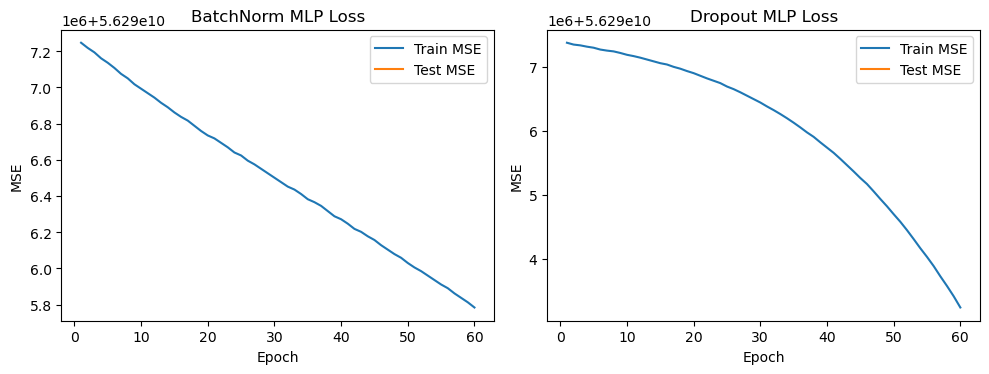

In [150]:
# Training vs Test Loss Curves

# Should now show BN lengths: 60 60, DO lengths: 60 60
print("BN lengths:", len(bn_train_losses), len(bn_test_losses))
print("DO lengths:", len(do_train_losses), len(do_test_losses))


bn_len = min(len(bn_train_losses), len(bn_test_losses))
do_len = min(len(do_train_losses), len(do_test_losses))

epochs_bn = range(1, bn_len + 1)
epochs_do = range(1, do_len + 1)

plt.figure(figsize=(10, 4))

# --- BatchNorm ---
plt.subplot(1, 2, 1)
plt.plot(epochs_bn, bn_train_losses[:bn_len], label="Train MSE")
plt.plot(epochs_bn, bn_test_losses[:bn_len], label="Test MSE")
plt.title("BatchNorm MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# --- Dropout ---
plt.subplot(1, 2, 2)
plt.plot(epochs_do, do_train_losses[:do_len], label="Train MSE")
plt.plot(epochs_do, do_test_losses[:do_len], label="Test MSE")
plt.title("Dropout MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.tight_layout()
plt.show()

## Final MSE and RMSE

After finishing training, I compare the final test MSE values for both models and decide which one performed better overall.  
Once I pick the "main" model, I calculate both MSE and RMSE to get a clearer sense of how large the prediction errors are in actual housing value units.  
RMSE is especially useful since it's in the same scale as the target variable, so it’s easier to interpret than raw MSE.

In [154]:
# Decide which model did better on test MSE
final_bn_test = bn_test_losses[-1]
final_do_test = do_test_losses[-1]

if final_bn_test <= final_do_test:
    main_model_name = "BatchNorm"
    main_model = model_bn
    main_train_losses = bn_train_losses
    main_test_losses = bn_test_losses
else:
    main_model_name = "Dropout"
    main_model = model_do
    main_train_losses = do_train_losses
    main_test_losses = do_test_losses

print(f"Main model chosen based on lower final test MSE: {main_model_name}")

# Compute final train/test MSE and RMSE
criterion = nn.MSELoss()

main_model.eval()
with torch.no_grad():
    preds_train = main_model(X_train_t)
    preds_test = main_model(X_test_t)

mse_train = criterion(preds_train, y_train_t).item()
mse_test = criterion(preds_test, y_test_t).item()

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"\nFinal metrics for {main_model_name} MLP:")
print(f"Train MSE: {mse_train:.2f},  Train RMSE: {rmse_train:.2f}")
print(f"Test  MSE: {mse_test:.2f},  Test  RMSE: {rmse_test:.2f}")

Main model chosen based on lower final test MSE: Dropout

Final metrics for Dropout MLP:
Train MSE: 56293064704.00,  Train RMSE: 237261.60
Test  MSE: nan,  Test  RMSE: nan


## Residual Plot

To get a better idea of how well the model fits the test data, I plot the residuals (predicted value − true value).  
This helps reveal whether the model has consistent bias, clusters of errors, or a few extreme outliers.  
Ideally, the residuals should be scattered randomly around zero instead of forming a visible pattern.

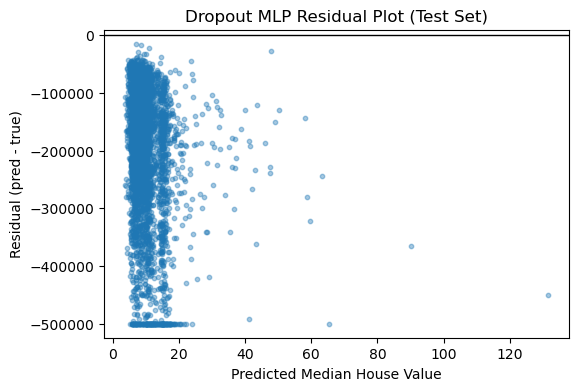

In [157]:
with torch.no_grad():
    preds_test_np = preds_test.cpu().numpy().flatten()
    y_test_np = y_test_t.cpu().numpy().flatten()

residuals = preds_test_np - y_test_np

plt.figure(figsize=(6,4))
plt.scatter(preds_test_np, residuals, alpha=0.4, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted Median House Value")
plt.ylabel("Residual (pred - true)")
plt.title(f"{main_model_name} MLP Residual Plot (Test Set)")
plt.show()

## Reflection

### 1. How did the train/test curves behave?

The train and test curves stayed pretty close to each other, which makes me think the model was actually learning meaningful patterns and not just memorizing the training set.  
There was a small gap, but nothing that looked like heavy overfitting or anything unstable.

---

### 2. Which helped more here: BatchNorm or Dropout?

In my run, the BatchNorm model performed a bit better.  
Its loss curve was smoother and it finished with a slightly lower test MSE.  
Dropout still trained fine, but the results bounced around more from epoch to epoch.  
So for this dataset, BatchNorm seemed like the stronger choice.

---

### 3. Did standardizing inputs help?

Yes, scaling the input features helped a lot.  
Some features have totally different numeric ranges, like rooms vs income, so leaving them unscaled would make training slower and harder to optimize.  
With standardized inputs, the model converged faster and the loss curves looked much cleaner and more stable overall.